In [ ]:
from utils.cub_config import Config
import torch
from torchvision import models, transforms
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward()

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1).squeeze()

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.cpu().numpy()
        
        cam = cv2.resize(cam, (448, 448))
        return cam

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

model_path = Config.MODEL_GRADCAM
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 200)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Usando dispositivo: cuda


C:\Users\Pichau\AppData\Local\Temp\ipykernel_4004\1054774539.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
target_layer = model.layer4[-1]

gradcam = GradCAM(model, target_layer)

In [5]:
preprocess = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
test_images = [
    "../data/CUB-200-2011/images/test/011.Rusty_Blackbird/Rusty_Blackbird_0006_6633.jpg",
    "../data/CUB-200-2011/images/test/027.Shiny_Cowbird/Shiny_Cowbird_0015_796858.jpg"
]

Grad-CAM salvo em: ../out\gradcam_Rusty_Blackbird_0006_6633.jpg


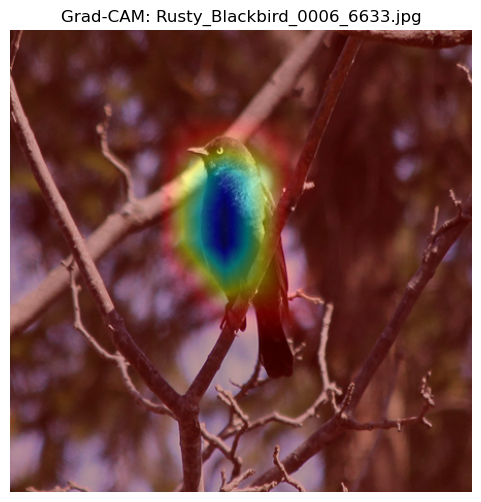

Grad-CAM salvo em: ../out\gradcam_Shiny_Cowbird_0015_796858.jpg


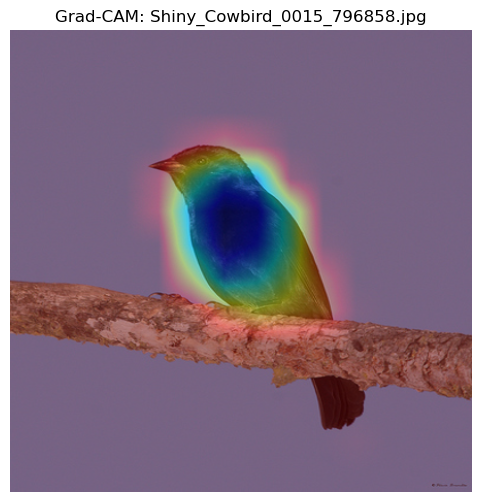

In [7]:
for img_path in test_images:
    img_name = os.path.basename(img_path)
    raw_img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(raw_img).unsqueeze(0).to(next(model.parameters()).device)

    cam = gradcam.generate(input_tensor)

    # Converte Grad-CAM em heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    raw_np = np.array(raw_img.resize((448, 448))) / 255.0
    overlay = heatmap * 0.4 + raw_np * 0.6
    overlay = np.clip(overlay, 0, 1)

    # Salva e exibe
    save_path = os.path.join(Config.OUTPUT_DIR, f"gradcam_{img_name}")
    plt.imsave(save_path, overlay)
    print(f"Grad-CAM salvo em: {save_path}")

    # --- Mostrar inline ---
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(f"Grad-CAM: {img_name}")
    plt.axis("off")
    plt.show()